## Training and Visualizing Decision Trees

A decision tree in general parlance represents a hierarchical series of binary decisions:

<img src="https://i.imgur.com/qSH4lqz.png" width="480">

Can you see how the model classifies a given input as a series of decisions? The tree is truncated here, but following any path from the root node down to a leaf will result in "Yes" or "No". Do you see how a decision tree differs from a logistic regression model?


**How a Decision Tree is Created**

Note the `gini` value in each box. This is the loss function used by the decision tree to decide which column should be used for splitting the data, and at what point the column should be split. A lower Gini index indicates a better split. A perfect split (only one class on each side) has a Gini index of 0. 

For a mathematical discussion of the Gini Index, watch this video: https://www.youtube.com/watch?v=-W0DnxQK1Eo . It has the following formula:

<img src="https://i.imgur.com/CSC0gAo.png" width="240">

Conceptually speaking, while training the models evaluates all possible splits across all possible columns and picks the best one. Then, it recursively performs an optimal split for the two portions. In practice, however, it's very inefficient to check all possible splits, so the model uses a heuristic (predefined strategy) combined with some randomization.

The iterative approach of the machine learning workflow in the case of a decision tree involves growing the tree layer-by-layer:

<img src="https://www.deepnetts.com/blog/wp-content/uploads/2019/02/SupervisedLearning.png" width="480">


Let's check the depth of the tree that was created.

A decision tree in machine learning works in exactly the same way, and except that we let the computer figure out the optimal structure & hierarchy of decisions, instead of coming up with criteria manually.

### Steps

1. Loading data from parquet and joblib.
2. Training a decision tree model using Scikit-learn.
3. Evaluating a model using a validation set and test set.
4. Hyperparameter Tuning and Overfitting.
5. Getting and saving predictions.
6. Conclusions about the model applied.

## Loading data from parquet and joblib

First of all, We get a simple extension for Jupyter Notebook and Jupyter Lab to beautify Python code automatically using Black.

In [13]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

Lets import the basic modules we are going to use.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<IPython.core.display.Javascript object>

The following settings will improve the default style and font sizes for our charts.

In [15]:
import matplotlib

sns.set_style("darkgrid")  # Dark grid background
matplotlib.rcParams["font.size"] = 14
matplotlib.rcParams["figure.figsize"] = (10, 6)
matplotlib.rcParams["figure.facecolor"] = "#00000000"
pd.set_option("display.max_columns", None)  # To show all columns

<IPython.core.display.Javascript object>

Let's read the data back using pd.read_parquet.

In [16]:
train_inputs = pd.read_parquet("../Datawarehouse/train_inputs.parquet")
val_inputs = pd.read_parquet("../Datawarehouse/val_inputs.parquet")
test_inputs = pd.read_parquet("../Datawarehouse/test_inputs.parquet")

train_targets = pd.read_parquet("../Datawarehouse/train_targets.parquet")[
    "Reached.on.Time_Y.N"
]
val_targets = pd.read_parquet("../Datawarehouse/val_targets.parquet")[
    "Reached.on.Time_Y.N"
]
# test_targets = pd.read_parquet('../Datawarehouse/val_targets.parquet')["Reached.on.Time_Y.N"]

<IPython.core.display.Javascript object>

Let's verify that the data was loaded properly.

In [17]:
print("train_inputs:", train_inputs.shape)
print("train_targets:", train_targets.shape)
print("val_inputs:", val_inputs.shape)
print("val_targets:", val_targets.shape)
print("test_inputs:", test_inputs.shape)
# print("test_targets:", test_targets)

train_inputs: (6749, 23)
train_targets: (6749,)
val_inputs: (2250, 23)
val_targets: (2250,)
test_inputs: (2000, 23)


<IPython.core.display.Javascript object>

There are some objects from EDA.ipynb that must be loaded back using joblib.load

In [18]:
import joblib

<IPython.core.display.Javascript object>

In [19]:
eda = joblib.load("../eda_basics_features.joblib")

<IPython.core.display.Javascript object>

Let's load each dataframe ready for the models

In [20]:
X_train = train_inputs[eda["numeric_cols"] + eda["encoded_cols"]]
X_val = val_inputs[eda["numeric_cols"] + eda["encoded_cols"]]
X_test = test_inputs[eda["numeric_cols"] + eda["encoded_cols"]]

<IPython.core.display.Javascript object>

## Training a decision tree model using Scikit-learn

We can use DecisionTreeClassifier from sklearn.tree to train a decision tree.

In [21]:
from sklearn.tree import DecisionTreeClassifier

<IPython.core.display.Javascript object>

In [22]:
model = DecisionTreeClassifier(random_state=527)

<IPython.core.display.Javascript object>

In [23]:
%%time
model.fit(X_train, train_targets)

CPU times: user 40.6 ms, sys: 79 µs, total: 40.6 ms
Wall time: 39.2 ms


DecisionTreeClassifier(random_state=527)

<IPython.core.display.Javascript object>

An optimal decision tree has now been created using the training data.

## Evaluating a model using a validation set and test set

Let's evaluate the decision tree using the accuracy score.

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix

<IPython.core.display.Javascript object>

In [25]:
train_preds = model.predict(X_train)
train_preds

array([0, 1, 1, ..., 0, 0, 1])

<IPython.core.display.Javascript object>

In [26]:
pd.value_counts(train_preds)

1    4298
0    2451
dtype: int64

<IPython.core.display.Javascript object>

The decision tree also returns probabilities for each prediction.

In [27]:
train_probs = model.predict_proba(X_train)
train_probs

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]])

<IPython.core.display.Javascript object>

* <mark>It looks like the decision tree is quite confident about its predictions.</mark>

Let's check the accuracy of its predictions.

In [28]:
accuracy_score(train_targets, train_preds)

1.0

<IPython.core.display.Javascript object>

* <mark>The training set accuracy is close to 100%! But we can't rely solely on the training set accuracy, we must evaluate the model on the validation set too.</mark>

We can make predictions and compute accuracy in one step using model.score

In [29]:
model.score(X_val, val_targets)

0.6786666666666666

<IPython.core.display.Javascript object>

* <mark>Although the training accuracy is 100%, the accuracy on the validation set is just about 67%, which is only marginally better then always predicting "No".</mark>

In [30]:
val_targets.value_counts() / len(val_targets)

1    0.631556
0    0.368444
Name: Reached.on.Time_Y.N, dtype: float64

<IPython.core.display.Javascript object>

* <mark>It appears that the model has learned the training examples perfect, and doesn't generalize well to previously unseen examples. This phenomenon is called "overfitting", and reducing overfitting is one of the most important parts of any machine learning project.</mark>

### Visualization

We can visualize the decision tree learned from the training data.

In [31]:
from sklearn.tree import plot_tree, export_text

<IPython.core.display.Javascript object>

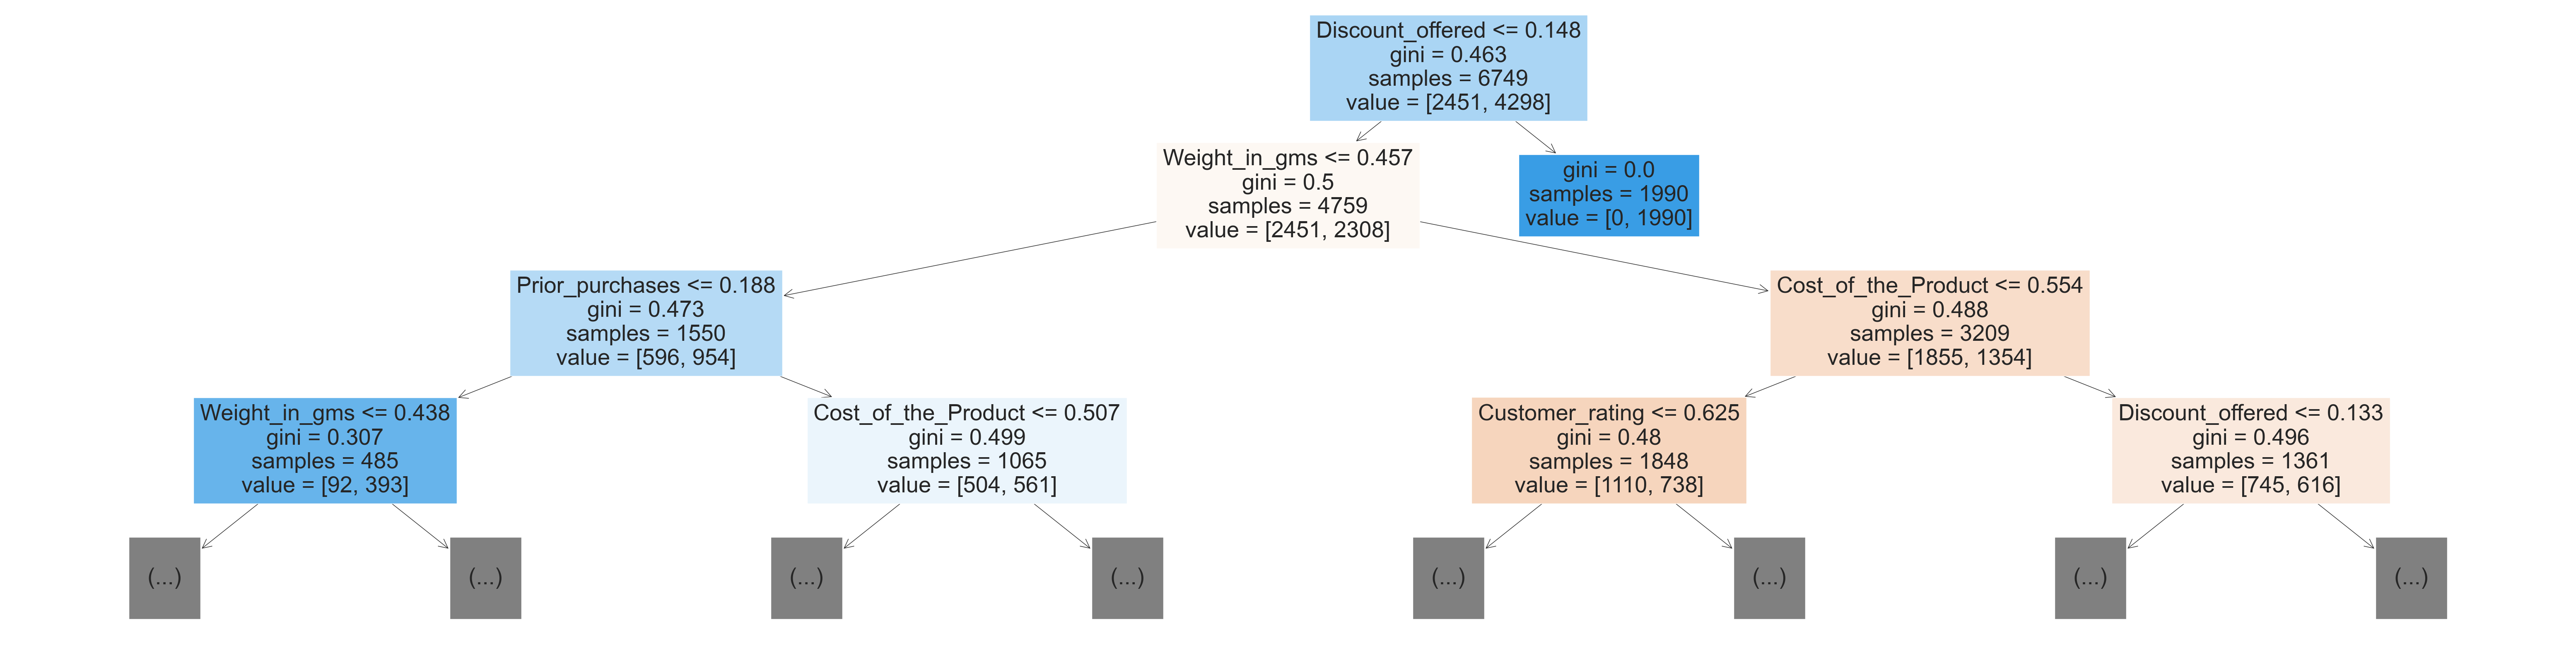

<IPython.core.display.Javascript object>

In [33]:
plt.figure(figsize=(80, 20))
plot_tree(
    model,
    feature_names=X_train.columns,
    max_depth=3,
    filled=True,
)

Let's check the depth of the tree that was created.

In [34]:
print("max_depth:", model.tree_.max_depth)
print("get_n_leaves:", model.get_n_leaves())

max_depth: 28
get_n_leaves: 1382


<IPython.core.display.Javascript object>

### Feature Importance

Based on the gini index computations, a decision tree assigns an "importance" value to each feature. These values can be used to interpret the results given by a decision tree.

In [35]:
model.feature_importances_

array([0.04420747, 0.04007517, 0.15746531, 0.04676134, 0.31617964,
       0.22885998, 0.01573422, 0.01005609, 0.01480954, 0.01408393,
       0.01838976, 0.01255626, 0.00754148, 0.01398107, 0.0089371 ,
       0.01224508, 0.01359888, 0.00830245, 0.01621525])

<IPython.core.display.Javascript object>

In [36]:
importance_df = pd.DataFrame(
    {
        "feature": train_inputs[eda["numeric_cols"] + eda["encoded_cols"]].columns,
        "importance": model.feature_importances_,
    }
).sort_values("importance", ascending=False)
importance_df

,feature,importance
4,Discount_offered,0.316180
5,Weight_in_gms,0.228860
2,Cost_of_the_Product,0.157465
3,Prior_purchases,0.046761
0,Customer_care_calls,0.044207
1,Customer_rating,0.040075
10,Warehouse_block_F,0.018390
18,Gender_M,0.016215
6,Warehouse_block_A,0.015734
8,Warehouse_block_C,0.014810


<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':'Feature Importance'}, xlabel='importance', ylabel='feature'>

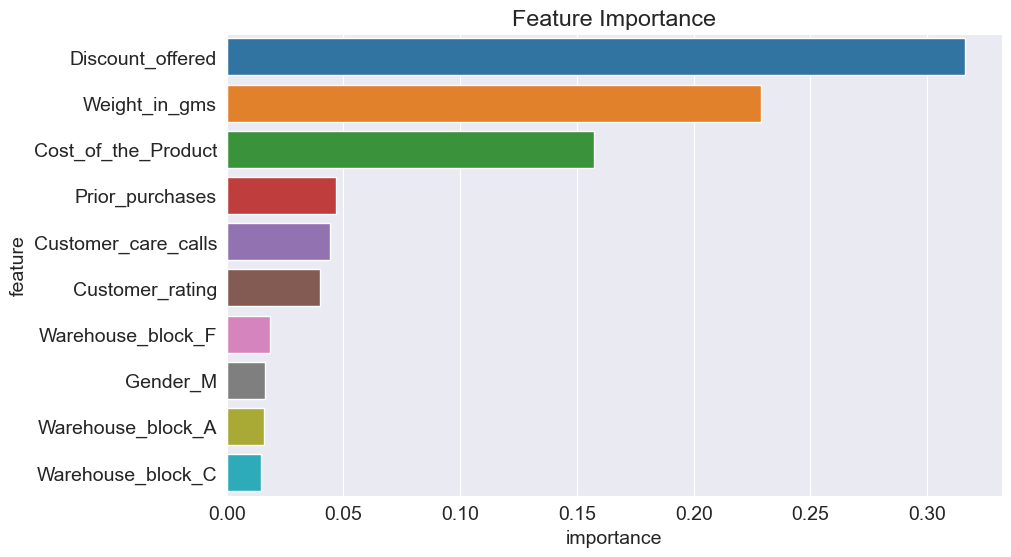

<IPython.core.display.Javascript object>

In [37]:
plt.title("Feature Importance")
sns.barplot(data=importance_df.head(10), x="importance", y="feature")

## Hyperparameter Tuning and Overfitting

As we saw in the previous section, our decision tree classifier memorized all training examples, leading to a 100% training accuracy, while the validation accuracy was only marginally better than a dumb baseline model. This phenomenon is called overfitting, and in this section, we'll look at some strategies for reducing overfitting. The process of reducing overfitting is known as regularlization.

The DecisionTreeClassifier accepts several arguments, some of which can be modified to reduce overfitting.

These arguments are called hyperparameters because they must be configured manually (as opposed to the parameters within the model which are learned from the data. We'll explore a couple of hyperparameters:

* max_depth
* max_leaf_nodes

### max_depth

By reducing the maximum depth of the decision tree, we can prevent the tree from memorizing all training examples, which may lead to better generalization

In [50]:
model = DecisionTreeClassifier(max_depth=22, random_state=527)

<IPython.core.display.Javascript object>

In [51]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(max_depth=22, random_state=527)

<IPython.core.display.Javascript object>

We can compute the accuracy of the model on the training and validation sets using model.score

In [52]:
model.score(X_train, train_targets)

0.9875537116609868

<IPython.core.display.Javascript object>

In [53]:
model.score(X_val, val_targets)

0.6875555555555556

<IPython.core.display.Javascript object>

In [54]:
model.classes_

array([0, 1])

<IPython.core.display.Javascript object>

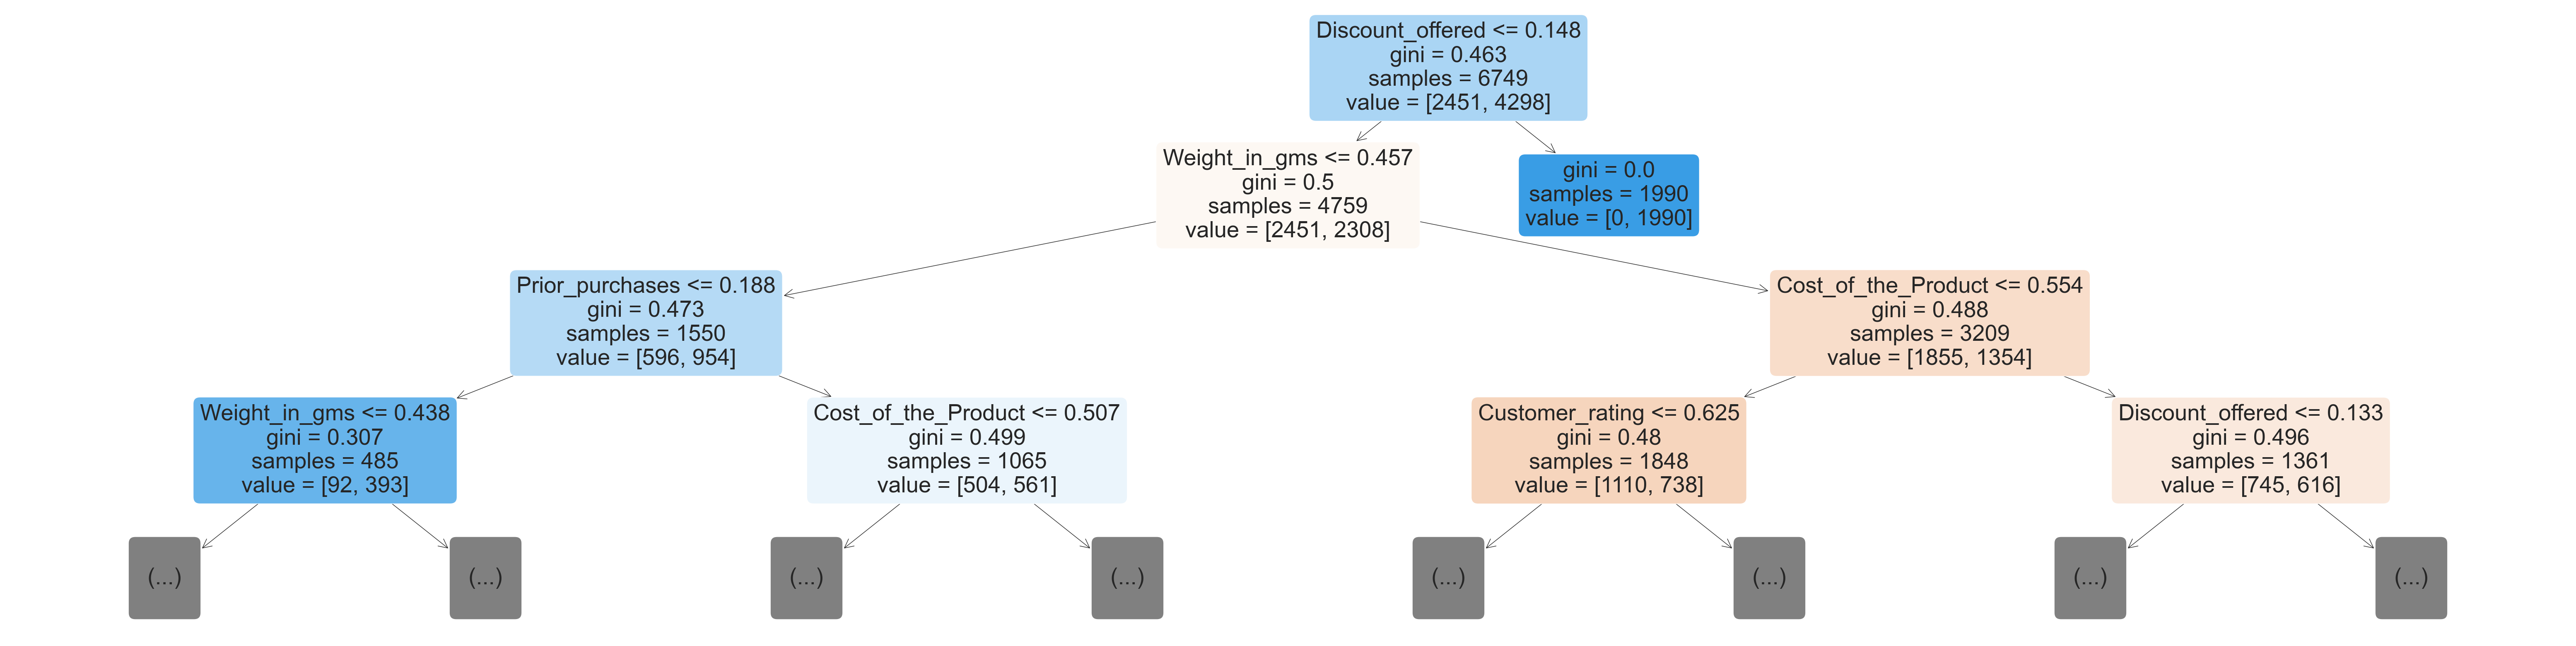

<IPython.core.display.Javascript object>

In [57]:
plt.figure(figsize=(80, 20))
plot_tree(
    model,
    feature_names=X_train.columns,
    filled=True,
    max_depth=3,
    rounded=True,
)

Let's experiment with different depths using a helper function.

In [71]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=527)
    model.fit(X_train, train_targets)
    train_acc = 1 - model.score(X_train, train_targets)
    val_acc = 1 - model.score(X_val, val_targets)
    return {"Max Depth": md, "Training Error": train_acc, "Validation Error": val_acc}

<IPython.core.display.Javascript object>

In [63]:
%%time
max_depth_error_df = pd.DataFrame([max_depth_error(md) for md in range(1, 28)])

CPU times: user 952 ms, sys: 0 ns, total: 952 ms
Wall time: 951 ms


<IPython.core.display.Javascript object>

In [64]:
max_depth_error_df

,Max Depth,Training Error,Validation Error
0,1,0.341977,0.339556
1,2,0.288932,0.310222
2,3,0.288932,0.310222
3,4,0.288932,0.303556
4,5,0.277671,0.296889
5,6,0.269966,0.316444
6,7,0.260483,0.313778
7,8,0.247444,0.296444
8,9,0.230108,0.305778
9,10,0.205956,0.296444


<IPython.core.display.Javascript object>

In [83]:
max_depth_error_df["Validation Error"].idxmin()

11

<IPython.core.display.Javascript object>

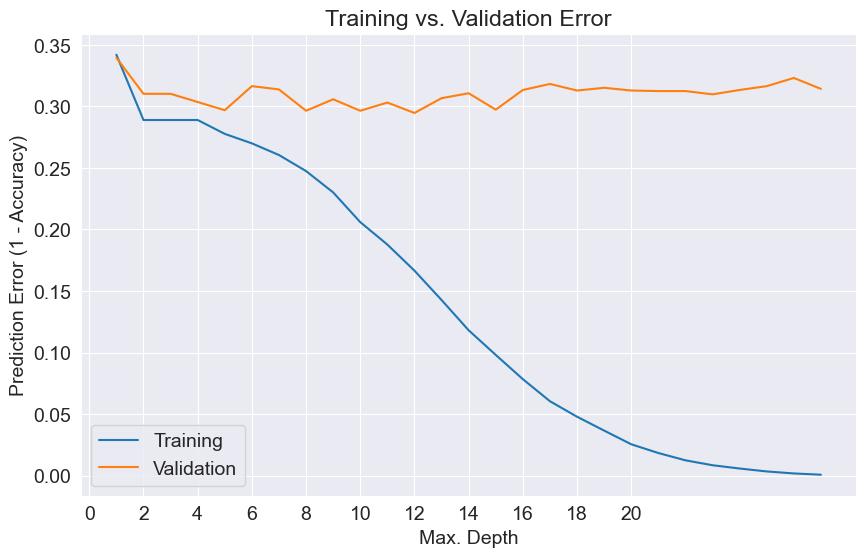

<IPython.core.display.Javascript object>

In [81]:
plt.figure()
plt.plot(max_depth_error_df["Max Depth"], max_depth_error_df["Training Error"])
plt.plot(max_depth_error_df["Max Depth"], max_depth_error_df["Validation Error"])
plt.title("Training vs. Validation Error")
plt.xticks(range(0, 21, 2))
plt.xlabel("Max. Depth")
plt.ylabel("Prediction Error (1 - Accuracy)")
plt.legend(["Training", "Validation"])

This is a common pattern you'll see with all machine learning algorithms:

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Trying with 12.

In [84]:
model = DecisionTreeClassifier(max_depth=12, random_state=527).fit(
    X_train, train_targets
)
model.score(X_val, val_targets)

0.7053333333333334

<IPython.core.display.Javascript object>

### max_leaf_nodes

Another way to control the size of complexity of a decision tree is to limit the number of leaf nodes. This allows branches of the tree to have varying depths.

In [85]:
model = DecisionTreeClassifier(max_leaf_nodes=500, random_state=527)

<IPython.core.display.Javascript object>

In [86]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(max_leaf_nodes=500, random_state=527)

<IPython.core.display.Javascript object>

In [87]:
model.score(X_train, train_targets)

0.8742035857164024

<IPython.core.display.Javascript object>

In [88]:
model.score(X_val, val_targets)

0.6933333333333334

<IPython.core.display.Javascript object>

Let's experiment with different max leaf nodes using a helper function.

In [89]:
def max_leaf_node_error(md):
    model = DecisionTreeClassifier(max_leaf_nodes=md, random_state=527)
    model.fit(X_train, train_targets)
    train_acc = 1 - model.score(X_train, train_targets)
    val_acc = 1 - model.score(X_val, val_targets)
    return {
        "Max leaf nodes": md,
        "Training Error": train_acc,
        "Validation Error": val_acc,
    }

<IPython.core.display.Javascript object>

In [90]:
%%time
max_leaf_node_error_df = pd.DataFrame([max_leaf_node_error(md) for md in range(2, 1382)])

CPU times: user 50.8 s, sys: 6.25 ms, total: 50.8 s
Wall time: 50.8 s


<IPython.core.display.Javascript object>

In [91]:
max_leaf_node_error_df

,Max leaf nodes,Training Error,Validation Error
0,2,0.341977,0.339556
1,3,0.288932,0.310222
2,4,0.288932,0.310222
3,5,0.288932,0.310222
4,6,0.288932,0.303556
...,...,...,...
1375,1377,0.000000,0.318222
1376,1378,0.000000,0.318222
1377,1379,0.000000,0.318222
1378,1380,0.000000,0.318222


<IPython.core.display.Javascript object>

In [92]:
max_leaf_node_error_df["Validation Error"].idxmin()

55

<IPython.core.display.Javascript object>

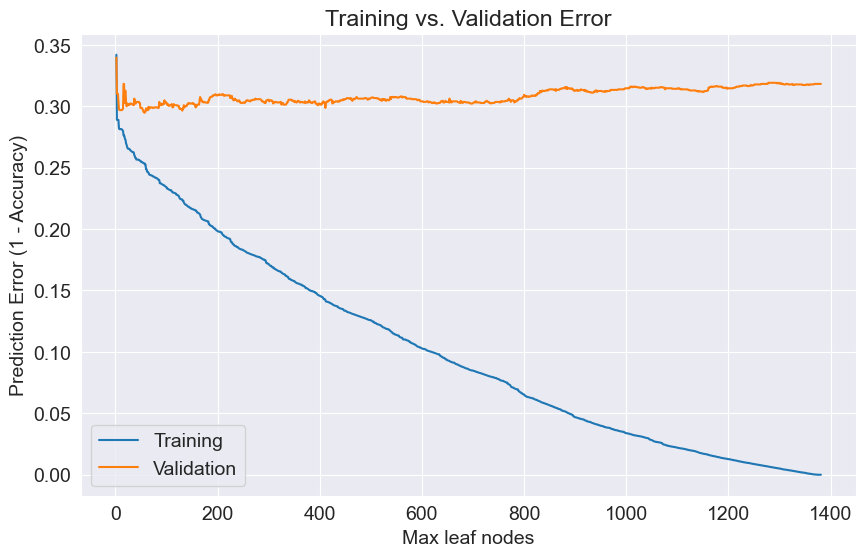

<IPython.core.display.Javascript object>

In [93]:
plt.figure()
plt.plot(
    max_leaf_node_error_df["Max leaf nodes"], max_leaf_node_error_df["Training Error"]
)
plt.plot(
    max_leaf_node_error_df["Max leaf nodes"], max_leaf_node_error_df["Validation Error"]
)
plt.title("Training vs. Validation Error")
# plt.xticks(range(0, 21, 2))
plt.xlabel("Max leaf nodes")
plt.ylabel("Prediction Error (1 - Accuracy)")
plt.legend(["Training", "Validation"])

This is a common pattern you'll see with all machine learning algorithms:

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Trying with 55:

In [101]:
model = DecisionTreeClassifier(max_leaf_nodes=55, random_state=527).fit(
    X_train, train_targets
)
model.score(X_val, val_targets)

0.7044444444444444

<IPython.core.display.Javascript object>

### Let's try both max_depth and max_leaf_nodes

In [102]:
model = DecisionTreeClassifier(max_depth=12, max_leaf_nodes=55, random_state=527).fit(
    X_train, train_targets
)
model.score(X_val, val_targets)

0.7044444444444444

<IPython.core.display.Javascript object>

* <mark>The model gets better, but it does not improve the two parameters working together.</mark>

## Getting and saving predictions

In [104]:
test_preds = model.predict(X_test)
len(test_preds)

2000

<IPython.core.display.Javascript object>

In [105]:
pd.DataFrame({"pred": test_preds}).to_csv(
    "../jorgeav527-decision-tree.csv", index=False
)

<IPython.core.display.Javascript object>

## Conclusions about the model applied